# Maximum Likelihood

:label:`sec_maximum_likelihood`


One of the most commonly encounter way of thinking in machine learning is the maximum likelihood point of view.  This is the concept that when working with a probabilistic model with unknown parameters, the parameters which make the data have the highest probability are the most likely ones.

## The Philosophy

This has a Bayesian which can be helpful to think about.  Suppose we have a model with parameters $\boldsymbol{\theta}$ and a collection of data points $X$.  For concreteness, we can imagine that $\boldsymbol{\theta}$ is a single value representing the probability that a coin comes up heads when flipped, and $X$ is a sequence of independent coin flips.  We will look at this example in depth later.

If we want to find the most likely value for the parameters of our model, that means we want to find

$$
\mathop{\mathrm{argmax}} P(\boldsymbol{\theta}\mid X).
$$

By Bayes' rule, this is the same thing as

$$
\mathop{\mathrm{argmax}} \frac{P(X \mid \boldsymbol{\theta})P(\boldsymbol{\theta})}{P(X)}.
$$

The expression $P(X)$, a parameter agnostic probability of generating the data, does not depend on $\boldsymbol{\theta}$ at all, and so can be dropped without changing the best choice of $\boldsymbol{\theta}$.  Similarly, we may now posit that we have no prior assumption on which set of parameters are better than any others, so we may declare that $P(\boldsymbol{\theta})$ does not depend on theta either!  This, for instance, makes sense in our coin flipping example where the probability it comes up heads could be any value in $[0,1]$ without any prior belief it is fair or not (often referred to as an *uninformative prior*).  Thus we see that our application of Bayes' rule shows that our best choice of $\boldsymbol{\theta}$ is the maximum likelihood estimate for $\boldsymbol{\theta}$:

$$
\hat{\boldsymbol{\theta}} = \mathop{\mathrm{argmax}} _ {\boldsymbol{\theta}} P(X \mid \boldsymbol{\theta}).
$$

As a matter of common terminology, the probability of the data given the parameters ($P(X \mid \boldsymbol{\theta})$) is referred to as the *likelihood*.

## A Concrete Example

Let us see how this works in a concrete example.  Suppose we have a single parameter $\theta$ representing the probability that a coin flip is heads.  Then the probability of getting a tails is $1-\theta$, and so if our observed data $X$ is a sequence with $n_H$ heads and $n_T$ tails, we can use the fact that independent probabilities multiply to see that 

$$
P(X \mid \theta) = \theta^{n_H}(1-\theta)^{n_T}.
$$

If we flip $13$ coins and get the sequence "HHHTHTTHHHHHT", which has $n_H = 9$ and $n_T = 4$, we see that this is

$$
P(X \mid \theta) = \theta^9(1-\theta)^4.
$$

One nice thing about this example will be that we know the answer going in.  Indeed, if I told we verbally, "I flipped 13 coins, and 9 came up heads, what is our best guess for the probability that the coin comes us heads?," I believe that everyone would correctly guess $9/13$.  What this maximum likelihood method will give us is a way to get that number from first principals, and in a way that will generalize to vastly more complex situations.

In any case, for our example, the plot of $P(X \mid \theta)$ is as follows

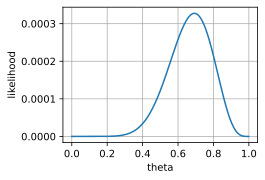

In [1]:
%matplotlib inline
import d2l
from mxnet import np, npx
npx.set_np()

theta = np.arange(0,1,0.001)
p = theta**9*(1-theta)**4.

d2l.plot(theta,p,'theta','likelihood')

This has its maximum value somewhere near our expected $9/13 \approx 0.7\ldots$.  To see if it is exactly there, we can turn to calculus.  Notice that at the maximum, the function is flat.  Indeed if the slope was not zero there, then we could shift the input to make it larger (think about the process of gradient descent).  Thus, we could find the maximum likelihood estimate by finding the values of $\theta$ where the derivative is zero, and finding the one that gives the highest probability.  We compute:

$$
\begin{aligned}
0 & = \frac{d}{d\theta} P(X \mid \theta) \\
& = \frac{d}{d\theta} \theta^9(1-\theta)^4 \\
& = 9\theta^8(1-\theta)^4 - 4\theta^9(1-\theta)^3 \\
& = \theta^8(1-\theta)^3(9-13\theta).
\end{aligned}
$$

This has three solutions: $0$, $1$ and $9/13$.  The first two are clearly minima, not maxima as they assign probability $0$ to our sequence.  The final one does *not* assign zero probability to our sequence, and thus must be the maximum likelihood estimate $\hat \theta = 9/13$, matching our intuition.

## Numerical Optimization and the $-\log$-Likelihood

This story is nice, but what is we have billions of parameters and data points.  What do we do then?

First notice that, if we make the assumption that all the data points are independents, we can no longer consider the likelihood itself as it is a product of many probabilities.  Indeed, each probability is in $[0,1]$, say typically of size about $1/2$, and the product of $(1/2)^{1000000000}$ is far below machine precision.  We cannot work with that directly.  

However, recall that the logarithm turns products to sums, in which case 

$$
\log((1/2)^{1000000000}) = 1000000000\cdot\log(1/2) \approx -301029995.6\ldots
$$

This number fits perfectly within even a single precision 32-bit float.  Thus, we are lead to consider the $\log$-likelihood, which is

$$
\log(P(X \mid \boldsymbol{\theta})).
$$

Since the function $x \mapsto \log(x)$ is increasing, maximizing the likelihood is the same thing as maximizing the $\log$-likelihood.  Indeed in :numref:`sec_naive_bayes` we saw this reasoning applied when working with the specific example of the Naive Bayes classifier.

We often work with loss functions, where we wish to minimize the loss.  We may turn maximum likelihood into the minimizattion of a loss by taking $-\log(P(X \mid \boldsymbol{\theta}))$, which is the $-\log$-Likelihood.

To illustrate this, consider the coin flipping problem from before, and pretend that we do not know the closed form solution.  The we may compute that

$$
-\log(P(X \mid \boldsymbol{\theta})) = -\log(\theta^{n_H}(1-\theta)^{n_T}) = -(n_H\log(\theta) + n_T\log(1-\theta))
$$

This can be written into code, and freely optimized with gradient descent even for billions of coin flips.

In [2]:
from mxnet import autograd, np, npx
npx.set_np()

### Set up our data ###
n_H = 8675309
n_T = 25624

### Initialize our paramteres ###
theta = np.array(0.5); theta.attach_grad()

### Perform gradient descent ###
lr = 0.00000000001
for iter in range(10) :
    with autograd.record():
        loss = -(n_H*np.log(theta) + n_T*np.log(1-theta))
    loss.backward()
    theta -= lr*theta.grad

### Check Output ###
theta, n_H/(n_H+n_T)

(array(0.50172704), 0.9970550284664874)

Numerical convenience is only one reason people like to use $-\log$-likelihoods.  Indeed, there are a number of reasons that it can be preferable.

### Simplification of Calculus Rules

As discussed above, due to independence assumptions, most probabilities we encounter in machine learning are products of individual probabilities.

$$
P(X\mid\boldsymbol{\theta}) = p(x_1\mid\boldsymbol{\theta})\cdot p(x_2\mid\boldsymbol{\theta})\cdots p(x_n\mid\boldsymbol{\theta}).
$$

This means that if we directly apply the product rule to compute a derivative we get

$$
\begin{aligned}
\frac{\partial}{\partial \boldsymbol{\theta}} P(X\mid\boldsymbol{\theta}) & = \left(\frac{\partial}{\partial \boldsymbol{\theta}}P(x_1\mid\boldsymbol{\theta})\right)\cdot P(x_2\mid\boldsymbol{\theta})\cdots P(x_n\mid\boldsymbol{\theta}) \\
& \quad + P(x_1\mid\boldsymbol{\theta})\cdot \left(\frac{\partial}{\partial \boldsymbol{\theta}}P(x_2\mid\boldsymbol{\theta})\right)\cdots P(x_n\mid\boldsymbol{\theta}) \\
& \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \vdots \\
& \quad + P(x_1\mid\boldsymbol{\theta})\cdot P(x_2\mid\boldsymbol{\theta}) \cdots \left(\frac{\partial}{\partial \boldsymbol{\theta}}P(x_n\mid\boldsymbol{\theta})\right)
\end{aligned}
$$

This requires $n(n-1)$ multiplications, along with $(n-1)$ additions, so it is total of quadratic time in the inputs!  Sufficient cleverness in grouping terms will reduce this to linear time, but it requires some thought.  For the $-\log$-likelihood we have instead

$$
-\log\left(P(X\mid\boldsymbol{\theta})\right) = -\log(P(x_1\mid\boldsymbol{\theta})) - \log(P(x_2\mid\boldsymbol{\theta})) \cdots - \log(P(x_n\mid\boldsymbol{\theta}))
$$

which then gives

$$
- \frac{\partial}{\partial \boldsymbol{\theta}} \log\left(P(X\mid\boldsymbol{\theta})\right) = \frac{1}{P(x_1\mid\boldsymbol{\theta})}\left(\frac{\partial}{\partial \boldsymbol{\theta}}P(x_1\mid\boldsymbol{\theta})\right) + \cdots + \frac{1}{P(x_n\mid\boldsymbol{\theta})}\left(\frac{\partial}{\partial \boldsymbol{\theta}}P(x_n\mid\boldsymbol{\theta})\right).
$$

This requires only $n$ divides and $n-1$ sums, and thus is linear time in the inputs.

### Relationships with Information Theory

In :numref:`sec_information_theory` we will discuss a concept known as information theory.  This is a rigorous mathematical theory which gives a way to measure the degree of randomness in a random variable.  The key object of study in that field is the entropy which is 

$$
H(p) = -\sum_{i} p_i \log_2(p_i),
$$

which measures the randomness of a source in bits. Notice that this is nothing more than the average $-\log$ probability, and thus if we take our $-\log$-likelihood and divide by the number of data points, we get a relative of entropy (known as cross-entropy) that measures how random our model thinks our data is.  This theoretical interpretation alone would be sufficiently compelling to motivate reporting the average $-\log$-likelihood over the dataset as a way of measuring model performance.

## Maximum likelihood for continuous variables

Everything that we have done so far assumes we are working with discrete random variables, but what if we want to work with continuous ones?  Indeed, in applications, continuous random variables are as likely to be encountered as discrete, and so we need to extend this story line to this case.

The short summary is that nothing at all changes, except we replace all the instances of the probability with the probability density.  Recalling that we write densities with lower case $p$, this means that for example we now say

$$
-\log\left(p(X\mid\boldsymbol{\theta})\right) = -\log(p(x_1\mid\boldsymbol{\theta})) - \log(p(x_2\mid\boldsymbol{\theta})) \cdots - \log(p(x_n\mid\boldsymbol{\theta})) = -\sum_i \log(p(x_i \mid \theta)).
$$

The question becomes, "Why is this OK?"  After all, the reason we introduced densities was because probabilities of getting specific outcomes themselves was zero, and thus is not the probability of generating our data for any set of parameters zero?

Indeed, this is the case, and understanding why we can shift to densities is an exercise in tracing what happens to the epsilons.

Let us first re-define our goal.  Let us suppose that for continuous random variables we no longer want to compute the probability of getting exactly the right value, but instead matching to say the first four digits.  For simplicity, Let us assume our data is repeated observations $x_1, \ldots, x_N$ of identically distributed random variables $X_1, \ldots, X_N$.  As we have seen previously, this can be written as

$$
P(X_1 \in [x_1,x_1+\epsilon], X_2 \in [x_2,x_2+\epsilon], \ldots, X_N \in [x_N,x_N+\epsilon]\mid\boldsymbol{\theta}) \approx \epsilon^Np(x_1\mid\boldsymbol{\theta})\cdot p(x_2\mid\boldsymbol{\theta}) \cdots p(x_n\mid\boldsymbol{\theta}),
$$

with $\epsilon = 10^{-4}$. Thus, if we take negative logarithms of this we obtain

$$
-\log(P(X_1 \in [x_1,x_1+\epsilon], X_2 \in [x_2,x_2+\epsilon], \ldots, X_N \in [x_N,x_N+\epsilon]\mid\boldsymbol{\theta})) \approx -N\log(\epsilon) - \sum_{i} \log(p(x_i\mid\boldsymbol{\theta})).
$$

If we examine this expression, the only place that the $\epsilon$ occurs is in the additive constant $-N\log(\epsilon)$.  This does not depend on the parameters $\boldsymbol{\theta}$ at all, so the optimal choice of $\boldsymbol{\theta}$ does not depend on our choice of $\epsilon$!  If we demand four digits or four-hundred, the best choice of $\boldsymbol{\theta}$ remains the same, thus we may freely drop the epsilon to see that what we want to optimize is

$$
- \sum_{i} \log(p(x_i\mid\boldsymbol{\theta})),
$$

as was claimed at the beginning of this section.  Thus we see that the maximum likelihood point of view can operate with continuous random variables as easily as with discrete ones by replacing the probabilities with probability densities.

## Summary
* The maximum likelihood principle tells us that the best fit model for a given dataset is the one that generates the data with the highest probability.
* Often people work with the $-\log$-likelihood instead for a variety of reasons: numerical stability, conversion of products to sums (and the resulting simplification of gradient computations), and theoretical ties to information theory.
* While simplest to motivate in the discrete setting, it may be freely generalized to the continuous setting as well by maximizing the probability density assigned to the datapoints.

## Exercises
1. Suppose you know that a random variable has density $\frac{1}{\alpha}e^{-\alpha x}$ for some value $\alpha$.  You obtain a single observation from the random variable which is the number $3$.  What is the maximum likelihood estimate for $\alpha$?
2. Suppose you have a dataset of samples $\{x_i\}_{i=1}^N$ drawn from a Gaussian with unknown mean, but variance $1$.  What is the maximum likelihood estimate for the mean?